# 5 Modeling Part II

This notebook explores the **`SARIMAX`** method to forecast electric load consumption and then compare it with the previous models(**`Elastic Net`**, **`XGB`** and **`LightGBM`**), generated in the previous notebook.

In the final section, the model with best performance will be selected and used to forecast hour-by-hour iteratively


## 5.1 Contents
 * 5 [Modeling Part II](#5-Modeling-Part-II)  
 * 5.1 [Contents](#5.1-Contents)  
 * 5.2 [Import Libraries](#5.2-Import-Libraries)  
 * 5.3  [Load datasets](#5.3-Load-Datasets)  
 * 5.4  [Time Series Decomposition](#5.4-Time-Series-Decomposition)
 * 5.5  [Time Series Differencing](#5.5-Time-Series-Differencing)
 * 5.6  [Dicky Fuller Test](#5.6-Dicky-Fuller-Test)
 * 5.7 [Auto correlation function (ACF) and Partial auto correlation function (PACF)](#5.7-Auto-correlation-function-(ACF)-and-Partial-auto-correlation-function-(PACF))
 * 5.8 [SARIMAX Model](#5.8-SARIMAX-Model)
     * 5.8.1 [Prediction Using SARIMAX Model](#5.8.1-Prediction-Using-SARIMAX-Model)
 * 5.9 [Final Model](#5.9-Final-Model)
     * 5.9.1[Iterative Prediction (hour-by-hour)](#5.9.1-Iterative-Prediction-(hour-by-hour))
 * 5.10 [Conclusion](#5.10-Conclusion)
 * 5.11 [Future works](#5.11-Future-works)

## 5.2 Import Libraries

In [2]:
# Import relevant libraries

import os, types
import io, requests

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from timeit import default_timer as timer
import datetime as dt
import pickle

# sklearn functions
from sklearn import __version__ as sklearn_version
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb
import lightgbm as gbm

# optimization
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit

# error metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import norm

# time series related libraries
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm

from library.sb_utils import save_file

import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

import shap

# 5.3 Load Datasets

In [3]:
# Reading back the saved file 
lagged_dict = np.load('./modified_data/lagged_dict.npy',allow_pickle='TRUE').item()

In [36]:
coast_df = lagged_dict['Coast']['load']
coast_df.head()

Date
2010-01-01 00:00:00    7931.241900
2010-01-01 01:00:00    7775.456846
2010-01-01 02:00:00    7704.815982
2010-01-01 03:00:00    7650.575724
2010-01-01 04:00:00    7666.708317
Freq: H, Name: load, dtype: float64

In [38]:
# Plotting the actual hourly load

def load_plot(df, start_time = None, end_time = None):
    """ This function plots all the columns of the dataframe
    
        df - name of the dataframe
        start_time - the time stamp where you start the plot
        end_time - the time stamp where you end the plot
        start_time and end_time must be a string format"""

    if start_time != None:
        if (type(start_time) or type(end_time)) != str:
           raise Exception('start_time or end_time is not a string')
    
#     ax_column = df.columns
    fig, ax = plt.subplots(figsize = (15,5))
    plt.subplots_adjust(hspace= 1.0)
#     for i, zone in enumerate(ax_column):
    ax.plot(df[start_time : end_time]) 
    ax.set_xlabel('Time', fontsize=12)
    ax.set_ylabel('Load (MW)', fontsize=12)
    ax.set_title('Coast Load')
    return ax

In [155]:
coast_df.shape

(100489,)

<AxesSubplot:title={'center':'Coast Load'}, xlabel='Time', ylabel='Load (MW)'>

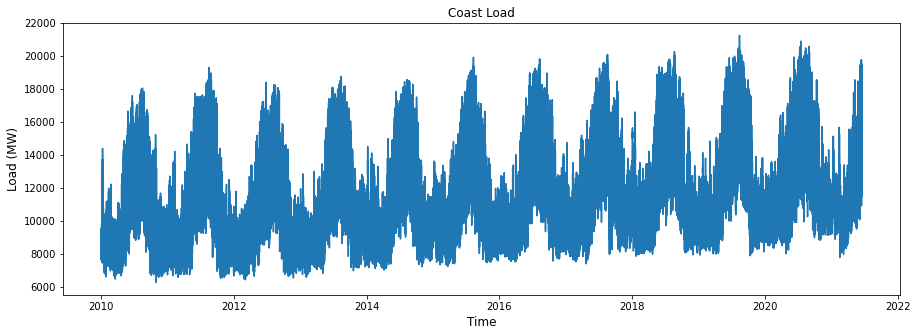

In [39]:
load_plot(coast_df)

- The above plot shows that the time series is not stationary. We can clearly see trend (increasing load with time) and seasonality in it.

In order to see clearly the components of the timeseries, we will decompse it to its components.




## 5.4 Time Series Decomposition

In [40]:
ts_decompose = sm.tsa.seasonal_decompose(coast_df, period=24*365)

In [42]:
def plotseasonal(res, axes ):
    
    res.observed.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Observed')
    res.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend')
    res.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal')
    res.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residual')

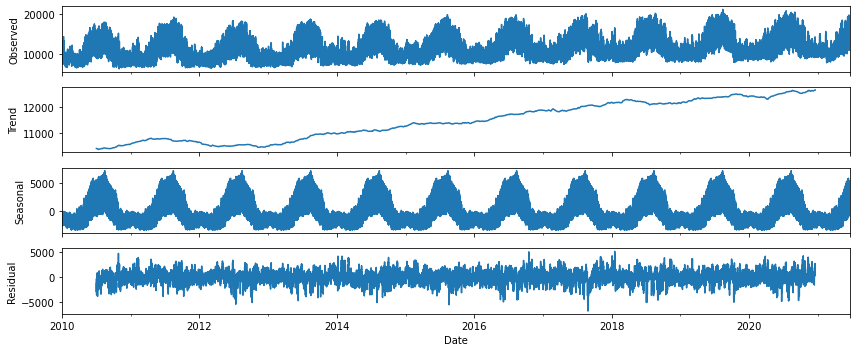

In [43]:
fig, ax = plt.subplots(4,1, sharex=True, figsize=(12,5))

plotseasonal(ts_decompose, ax[:])
plt.tight_layout()
plt.show()


After decomposition, the trend and seasonality are very clear.

    - over the last decade there is a steady increase in electric consumption. It increased by about 22%
    - there is yearly seasonality, very high demand every summer

One assumption when predicting timeseries data is stationarity and our data seems non-stationary. One wat to achieve stationarity is by differencing.

## 5.5 Time Series Differencing

In [44]:
ts_diff1hr_decompose = sm.tsa.seasonal_decompose(coast_df.diff().dropna(), period=24*365)
ts_diff24hr_decompose = sm.tsa.seasonal_decompose(coast_df.diff().dropna().diff(24).dropna(), period=24*365)

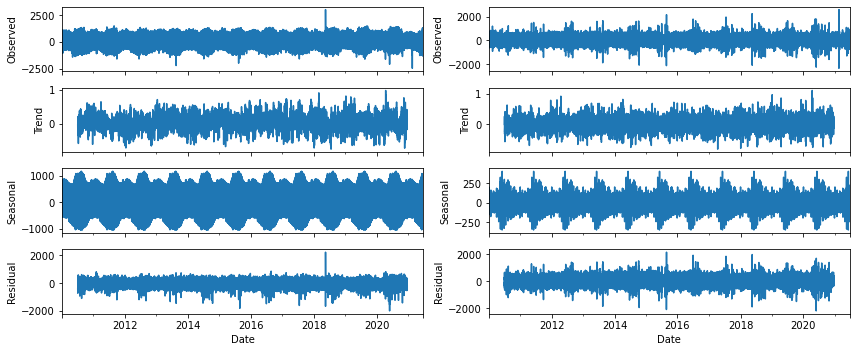

In [45]:
fig, ax = plt.subplots(4,2, sharex=True, figsize=(12,5))

plotseasonal(ts_diff1hr_decompose, ax[:,0])
plotseasonal(ts_diff24hr_decompose, ax[:,1])
# ax[:,0].set_title('1 Hour Differencing')
# ax[:,1].set_title('24 Hour Differencing')
plt.tight_layout()
plt.show()

The trend observed in the original data is removed after differencing (both with a single hour or 24 hour differencing). However, the seasonality still persists in both

## 5.6 Dicky Fuller Test

In [46]:
def RunAdfuller(df):
    result = adfuller(df)
    print("t-stat", result[0])
    print("p-value", result[1])
    print("lags used", result[2])
    print("critical values", result[4]) 

In [47]:
# Adfuller test for original timeseries
RunAdfuller(coast_df)

t-stat -8.802624695382198
p-value 2.0923167812892e-14
lags used 67
critical values {'1%': -3.4304151205142763, '5%': -2.861568782248399, '10%': -2.5667853197834343}


In [48]:
# Adfuller test after single hour differencing
RunAdfuller(coast_df.diff().dropna())

t-stat -55.93977516923448
p-value 0.0
lags used 68
critical values {'1%': -3.4304151218112855, '5%': -2.8615687828216507, '10%': -2.566785320088557}


In [49]:
# Adfuller test after 24 hour differencing
RunAdfuller(coast_df.diff().dropna().diff(24).dropna())

t-stat -57.32942347376016
p-value 0.0
lags used 68
critical values {'1%': -3.4304151373794256, '5%': -2.8615687897024493, '10%': -2.5667853237509783}


In all three cases the t-stat value is < than the critical values and the p-value = 0. Hence we can consider the time series as stationary. This observation may conflict with the previous decompsotion results that indicate trend and seasonality. Onething to consider is the trend observed may not be that big??/

## 5.7 Auto correlation function (ACF) and Partial auto correlation function (PACF)

ACF is the correlation of the time series observations calculated with values of the same series at previous times. It is used to determine the moving average (MA or q) term of the ARIMA(p,d,q) models. PACF is a summary of the relationship between an observation in a time series with observations at prior time steps, with the relationships of intervening observations removed. It is used to determine the auto regression (AR or p) term of the ARIMA(p,d,q) models.

In [50]:
# Plot ACF AND PACF 

def Plot_Acf_Pacf(df, lag):
    fig,(ax1,ax2) = plt.subplots(2,1, figsize = (12,5))
    plt.subplots_adjust(hspace=0.3)
    plot_acf(df, lags = lag, zero = False, ax = ax1, alpha = 0.05)
    plot_pacf(df, lags = lag, zero = False, ax = ax2, alpha = 0.05)

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.


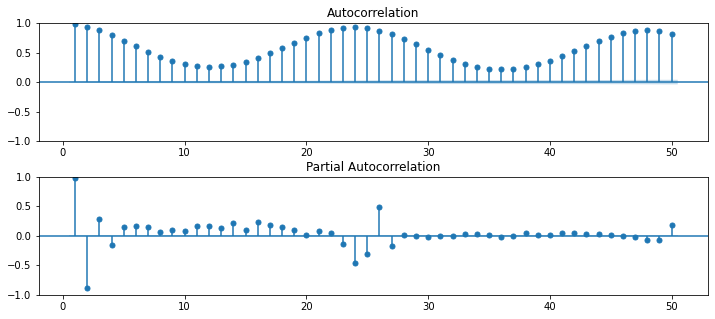

In [51]:

Plot_Acf_Pacf(coast_df, 50)

In [52]:
# take differencing to remove trend and seasonality from the data
diff_df = coast_df.diff().dropna().diff(24).dropna().diff(24*365).dropna()

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.


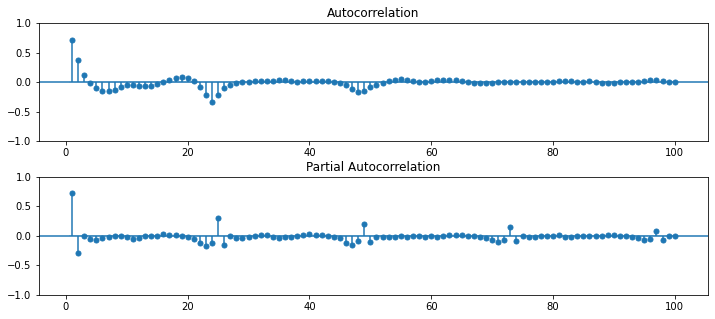

In [53]:
Plot_Acf_Pacf(diff_df, 100)

The 24 hour periodicity is quite obvious in the ACF plot from the original Input data. However both ACF and PACF plots did not give us a clear result as to what values to use for p and q. One main reason could be the multiple seasonailty present in the data.

Talk about how to use ACF and PACF to estimate p and q.


In the presence of multiple seasonality, one way to capture this seasonality is to add the Fourie terms.



In [156]:
lagged_dict['Coast'].shape

(100489, 74)

In [54]:
def FourierTerms(data,k):
    
#     if type(data) is dict:
        
        df = data.copy()
        for k in range(1,k+1):
            

            df['sin_hour'+str(k)] = np.sin((2*k*np.pi*df.index.hour)/24)
            df['cos_hour'+str(k)] = np.cos((2*k*np.pi*df.index.hour)/24)  
                                        
            df['sin_week'+str(k)] = np.sin((2*k*np.pi*df.index.dayofweek)/7)
            df['cos_week'+str(k)] = np.cos((2*k*np.pi*df.index.dayofweek)/7)  
                                        
            df['sin_year'+str(k)] = np.sin((2*k*np.pi*df.index.dayofyear)/365.25)
            df['cos_year'+str(k)] = np.cos((2*k*np.pi*df.index.dayofyear)/365.25)  
        
#             fourier_df = df
        return df

In [55]:
fourier_coast_df = FourierTerms(lagged_dict['Coast'],5)

In [244]:
pd.set_option('display.max_columns', None)
# fourier_coast_df.head()

<p>&nbsp;</p>
Since the SARIMAX models use lagged time by default for prediction, we don not need the lagged features we created in the data for the prvious modeling.


In [57]:
fr_coast = fourier_coast_df.drop([col for col in fourier_coast_df if col.startswith('load_lag')], axis =1)

In [58]:
fr_coast.head()

,tempC,windspeedKmph,winddirDegree,precipMM,humidity,visibility,pressure,cloudcover,HeatIndexC,DewPointC,WindChillC,WindGustKmph,FeelsLikeC,uvIndex,appr_temp,region,winddir16Point,weatherCategory,load,dates,hour,day,month,year,weekday,holiday,working_day,covid_confirmed,covid_deaths,appr_temp_lag1,appr_temp_lag2,appr_temp_lag3,appr_temp_lag4,appr_temp_lag5,appr_temp_lag6,appr_temp_lag12,appr_temp_lag24,appr_temp_lag48,appr_temp_lag120,appr_temp_lag144,appr_temp_lag168,appr_temp_lag192,appr_temp_lag336,appr_temp_lag360,appr_temp_lag504,appr_temp_lag672,appr_temp_lag768,appr_temp_lag8064,appr_temp_lag8760,roll_mean,roll_median,roll_std,roll_min,roll_max,sin_hour1,cos_hour1,sin_week1,cos_week1,sin_year1,cos_year1,sin_hour2,cos_hour2,sin_week2,cos_week2,sin_year2,cos_year2,sin_hour3,cos_hour3,sin_week3,cos_week3,sin_year3,cos_year3,sin_hour4,cos_hour4,sin_week4,cos_week4,sin_year4,cos_year4,sin_hour5,cos_hour5,sin_week5,cos_week5,sin_year5,cos_year5
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-01-01 00:00:00,8.0,14.0,335.0,0.00,90.0,10.0,1026.0,70.0,8.0,7.0,4.0,20.0,4.0,1.0,4.459418,Coast,NNW,cloudy,7931.241900,2010-01-01,0.0,1.0,1.0,2010.0,Friday,1.0,0.0,0.0,0.0,5.320780,5.320780,6.182142,8.191454,8.191454,10.200766,20.013598,7.545843,4.052842,4.795290,-1.404899,-2.440243,18.760611,2.471460,4.919010,1.855022,1.221840,21.756105,1.802891,6.385142,8689.593481,8983.254286,693.692186,7466.132671,9684.165433,0.000000,1.000000,-0.433884,-0.900969,0.017202,0.999852,0.000000,1.000000e+00,0.781831,0.62349,0.034398,0.999408,0.000000e+00,1.000000e+00,-0.974928,-0.222521,0.051584,0.998669,0.000000e+00,1.0,0.974928,-0.222521,0.068755,0.997634,0.000000,1.000000,-0.781831,0.62349,0.085906,0.996303
2010-01-01 01:00:00,7.0,19.5,336.5,0.05,88.5,10.0,1027.5,76.0,7.0,5.5,3.0,28.5,3.0,1.0,2.139906,Coast,NNW,cloudy,7775.456846,2010-01-01,1.0,1.0,1.0,2010.0,Friday,1.0,0.0,0.0,0.0,4.459418,5.320780,5.320780,6.182142,8.191454,8.191454,18.059169,6.426871,4.751073,3.253999,-1.158439,-4.100976,18.699556,2.374237,4.565472,1.640410,0.720318,15.895605,0.989257,5.422290,8673.585860,8983.254286,707.006814,7466.132671,9684.165433,0.258819,0.965926,-0.433884,-0.900969,0.017202,0.999852,0.500000,8.660254e-01,0.781831,0.62349,0.034398,0.999408,7.071068e-01,7.071068e-01,-0.974928,-0.222521,0.051584,0.998669,8.660254e-01,0.5,0.974928,-0.222521,0.068755,0.997634,0.965926,0.258819,-0.781831,0.62349,0.085906,0.996303
2010-01-01 02:00:00,7.0,19.5,336.5,0.05,88.5,10.0,1027.5,76.0,7.0,5.5,3.0,28.5,3.0,1.0,2.139906,Coast,NNW,cloudy,7704.815982,2010-01-01,2.0,1.0,1.0,2010.0,Friday,1.0,0.0,0.0,0.0,2.139906,4.459418,5.320780,5.320780,6.182142,8.191454,18.059169,6.426871,4.751073,3.253999,-1.158439,-4.100976,18.699556,2.374237,4.565472,1.640410,0.720318,15.895605,0.989257,5.422290,8671.454090,8983.254286,709.743461,7466.132671,9684.165433,0.500000,0.866025,-0.433884,-0.900969,0.017202,0.999852,0.866025,5.000000e-01,0.781831,0.62349,0.034398,0.999408,1.000000e+00,6.123234e-17,-0.974928,-0.222521,0.051584,0.998669,8.660254e-01,-0.5,0.974928,-0.222521,0.068755,0.997634,0.500000,-0.866025,-0.781831,0.62349,0.085906,0.996303
2010-01-01 03:00:00,6.0,25.0,338.0,0.10,87.0,10.0,1029.0,82.0,6.0,4.0,2.0,37.0,2.0,1.0,-0.179606,Coast,NNW,cloudy,7650.575724,2010-01-01,3.0,1.0,1.0,2010.0,Friday,1.0,0.0,0.0,0.0,2.139906,2.139906,4.459418,5.320780,5.320780,6.182142,16.104741,5.307898,5.449305,1.712708,-0.911978,-5.761709,18.638501,2.277015,4.211935,1.425798,0.218796,10.035106,0.175623,4.459439,8679.994104,8983.254286,696.135884,7466.132671,9684.165433,0.707107,0.707107,-0.433884,-0.900969,0.017202,0.999852,1.000000,6.123234e-17,0.781831,0.62349,0.034398,0.999408,7.071068e-01,-7.071068e-01,-0.974928,-0.222521,0.051584,0.998669,1.224647e-16,-1.0,0.974928,-0.222521,0.068755,0.997634,-0.707107,-0.707107,-0.781831,0.62349,0.085906,0.996303
2010-01-01 04:00:00,5.5,15.5,172.5,0.15,86.5,9.5,1029.0,51.5,5.5,3.5,1.5,23.0,1.5,1.5,1.063339,Coast,NNW,cloudy,766

In [161]:
fr_coast.shape

(100489, 84)

#### Helper Funcations

In [59]:
# extracting the name of the numeric features
df_numeric_features = fr_coast.copy()
df_numeric_features.drop(columns=['winddir16Point','dates','covid_confirmed','covid_deaths'], inplace=True)

df_numeric_features = df_numeric_features.select_dtypes(include=[np.number])
df_numeric_features.drop(columns=['load'],inplace=True) # drop 'load' as this is our target y value
numeric_features = df_numeric_features.columns

In [60]:
def SplitEncodeTranf(train_data,test_data):
    
    """ This function will read the name of the region and will perform the following steps:
        1. It will select the region from the training and test dictionaries
        2. Will drop the features mentioned above
        3. Encode the categorical features
        3. Split the data into X_train, X_test, y_train and y_test
        4. Apply standard scaling to the X_train and X_test datasets
    """
    
    
    cat_columns = ['weatherCategory','year','month','day','hour','weekday','holiday','working_day']

    # for training dataset
    
    df_encode_tr = train_data.copy()
    df_encode_tr.drop(columns=['winddir16Point','dates','covid_confirmed','covid_deaths'], inplace=True)
    [df_encode_tr[col].astype('category') for col in cat_columns] # ensures these are type object
    df_encode_tr = pd.get_dummies(df_encode_tr, drop_first = True) # encodes categorical features
   
    y_train = df_encode_tr.loc[:, 'load']
    X_train = df_encode_tr.drop(['load'], axis =1)
    
    # for test dataset
    
    df_encode_tst = test_data.copy()
    df_encode_tst.drop(columns=['winddir16Point','dates','covid_confirmed','covid_deaths'], inplace=True)
    [df_encode_tst[col].astype('category') for col in cat_columns] # ensures these are type object
    df_encode_tst = pd.get_dummies(df_encode_tst, drop_first = True) # encodes categorical features
   
    
    y_test = df_encode_tst.loc[:, 'load']
    X_test = df_encode_tst.drop(['load'], axis =1)
     
    # Use standard scaler to scale the numeric features
    
    scaler = StandardScaler()
    X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
    X_test[numeric_features] = scaler.transform(X_test[numeric_features])
    
    return X_train, X_test, y_train, y_test

In [181]:
def LaggedFeatures(data,feature,laglist, dropna=True):
    
    """ This function creates lagged feature by shifting the values of a given 
    column by the specified amount.
    
    data : is the input data in a dictionary format
    feature :  contains the name of the column to lag or shift
    laglist : contains the lag amount to shift the feature column by
    dropna : if true will drop the NaN created after shifting
    
    """    
    df = data.copy()
    for j in range(len(feature)):
        for i in laglist:
            df['%s_lag%d'%(feature[j],i)] = df[feature[j]].shift(i)
        if dropna:
            df = df.dropna()
        else:
            df = df
    return df


In [61]:
# A funcation to compute the error metrics
def ErrorMetrics(observed, predicted, model_name = None):
    
    """ 
    This function will compute the error associated with a given model
        it will calculate the r2_score, MAE, MSE, RMSE and MAPE
        y_true = the actual target values
        y_pred = the predict values
    """
    
    R_squared = r2_score(observed,predicted)
    MAE = mean_absolute_error(observed,predicted)
    MSE = mean_squared_error(observed,predicted)
    RMSE = np.sqrt(MSE)
    MAPE = np.mean(np.abs((observed - predicted) / observed)) * 100
    
    print('Error metrics for {}'.format(model_name))
    print('R2 score = {:.4f}'.format(R_squared))
    print('MAE = {:.4f}'.format(MAE))
    #print('Mean squared error is {:.4f}'.format(MSE))
    print('RMSE =  {:.4f}'.format(RMSE))
    print('MAPE =  {:.4f}%'.format(MAPE))
    return R_squared, RMSE, MAPE 

In [121]:
# A function to plot observed vs predicted electric load

def Plot_Pred2(observed, predicted, model_name = None,conf_level=None, scatter=False):
    
    """ This function will read the observed and predicted values
    and plots a line and scatter plots
    """
    fig,ax1 = plt.subplots(figsize=(15,6))
    ax1.plot(observed.index, observed.values, label = 'Observed')
    ax1.plot(observed.index, predicted, label = 'Predicted')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Load (MW)')
    ax1.set_title('Observed vs Predicted Load (%s)'% model_name)
    
#     if conf_level:
    plt.fill_between(conf_level.index, conf_level['lower load'], conf_level['upper load'], color='pink')
    
    start_t = observed.index[-168]
    end_t = observed.index.max()
    ax1.set_xlim([start_t , end_t])
    plt.legend(loc='best', prop={'size':16})
    
    if scatter:
        fig,ax2 = plt.subplots(figsize=(6,6))
        minx = df_coast.load.min() - 500
        maxx = df_coast.load.max() + 500

    plt.legend(loc='best', prop={'size':16})
    plt.show()

In [63]:
# create dictionaries for training and testing datasets
# we will use 8760 + 1 to make sure the separation happens at the end of 1 day
split_index = 8761

fr_coast_train = fr_coast.iloc[:-split_index, :]
fr_coast_test = fr_coast.iloc[-split_index:, :]

In [64]:
X_train, X_test, y_train, y_test = SplitEncodeTranf(fr_coast_train,fr_coast_test)

In [167]:
# X_train.head()

In [65]:
X_train_3yr = X_train[-26304:]
y_train_3yr = y_train[-26304:]

## 5.8 SARIMAX Model

In [ ]:

# opt_param = pm.auto_arima(y_train_lag, #data
                    d=1, 
                    start_p=0, 
                    start_q=0, 
                    max_p=2, 
                    max_q=2,
                    exogenous= X_train_lag, 
                    seasonal=True, 
                    m=24, 
                    #D=1, 
                    start_P=1, 
                    start_Q=1, 
                    max_P=1, 
                    max_Q=1, 
                    information_criterion='aic', 
                    trace=False, 
                    error_action='ignore', 
                    stepwise=True, 
                    )
#opt_param.fit(y_train_3yr, exogenous= X_train_3yr)

The above auto-arima was run to obtain the best SARIMAX orders for our data. The best parameters are (2,1,1)x(1,0,1,24) corresponding to the (p,d,q)x(P,D,Q,s). This means, our model will use two auto-regressive terms, one moving avergae and one differencing. For the seasonality it will use a period of 24 hours and oe term auto regressive and moving average terms without any differencing.


In [66]:
# Using the optimal SARIMAX orders obtained from running the above auto_arima function. 
start = timer()
model_opt = SARIMAX(y_train_3yr, order=(2,1,1), seasonal_order=(1, 0, 1, 24), exog = X_train_3yr, trend='c')

end = timer()
print('elapsed time is',format(round(end-start)))

elapsed time is 1


In [67]:
start = timer()

results = model_opt.fit()

end = timer()
print('elapsed time is',format(round(end-start)))

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
Non-invertible starting MA parameters found. Using zeros as starting parameters.


elapsed time is 2982


In [116]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                               load   No. Observations:                26304
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 24)   Log Likelihood             -171230.135
Date:                            Tue, 18 Jan 2022   AIC                         342792.269
Time:                                    22:17:44   BIC                         344149.724
Sample:                                06-19-2017   HQIC                        343230.567
                                     - 06-18-2020                                         
Covariance Type:                              opg                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
intercept                              -0.4044      0.261     -1.548      0.122      -0.916       0.107
tempC                                2965.2128     95.992     30.890      0.000    2777.072    3153.353
windspeedKmph                        -119.4039     10.699    -11.160      0.000    -140.373     -98.435
winddirDegree                         -31.8877      2.087    -15.282      0.000     -35.977     -27.798
precipMM                               -2.3659      1.733     -1.365      0.172      -5.763       1.031
humidity                               24.8740     15.954      1.559      0.119      -6.395      56.143
visibility                            -22.5295      2.710     -8.313      0.000     -27.841     -17.218
pressure                               63.3190     15.188      4.169      0.000      33.551      93.087
cloudcover                            -17.8096      3.591     -4.959      0.000     -24.849     -10.771
HeatIndexC                            338.3091     27.147     12.462      0.000     285.101     391.517
DewPointC                            -364.6937     21.802    -16.728      0.000    -407.424    -321.963
WindChillC                          -2115.8028     40.052    -52.826      0.000   -2194.304   -2037.302
WindGustKmph                            1.9201      4.919      0.390      0.696      -7.722      11.562
FeelsLikeC                            410.2645     32.000     12.821      0.000     347.546     472.983
uvIndex                              -152.1298      7.913    -19.226      0.000    -167.638    -136.621
appr_temp                           -1450.5485     91.033    -15.934      0.000   -1628.970   -1272.127
appr_temp_lag1                          7.5864     19.309      0.393      0.694     -30.258      45.431
appr_temp_lag2                        381.0320     20.417     18.663      0.000     341.016     421.048
appr_temp_lag3                        283.1657     21.472     13.188      0.000     241.082     325.250
appr_temp_lag4                        209.3057     20.431     10.245      0.000     169.262     249.349
appr_temp_lag5                        383.8727     22.870     16.785      0.000     339.048     428.697
appr_temp_lag6                        438.8700     18.225     24.080      0.000     403.149     474.591
appr_temp_lag12                       -55.6095     12.567     -4.425      0.000     -80.239     -30.980
appr_temp_lag24                      -102.9606     11.958     -8.610      0.000    -126.399     -79.522
appr_temp_lag48                       -22.8569     11.999     -1.905      0.057     -46.375       0.661
appr_temp_lag120                      -57.5006     12.031     -4.780      0.000     -81.080     -33.921
appr_temp_lag144                      -98.2603     12.235     -8.031      0.000    -122.241     -74.279
appr_temp_lag

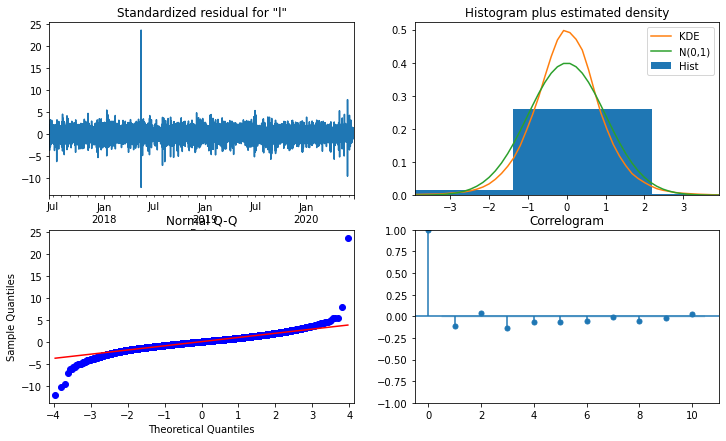

In [126]:
# plotting the residuals and checking if they meet the i.i.d requirements
# fig,ax = plt.subplots(figsize=(15, 5))
fig.subplots_adjust(hspace=1)
results.plot_diagnostics(figsize=(12, 7))
plt.show()

### 5.8.1 Prediction Using SARIMAX Model

In [72]:
# prediction using training data
pred = results.get_prediction(start=X_train_3yr.index[-24*7], end=X_train_3yr.index[-1], 
                              dynamic=True, exog=X_train_3yr.iloc[-24*7:, :])
pred_conf_int = pred.conf_int()

y_pred = pred.predicted_mean
y_lower_limits = pred_conf_int.loc[:,'lower load']
y_upper_limits = pred_conf_int.loc[:,'upper load']

In [136]:
ErrorMetrics(y_train_3yr.iloc[-24*7:],y_pred,'SARIMAX prediction using training set')

Error metrics for SARIMAX
R2 score = 0.4509
MAE = 1705.8653
RMSE =  2058.2615
MAPE =  11.3965%


(0.45085904536472976, 2058.2614703789595, 11.396519728557829)

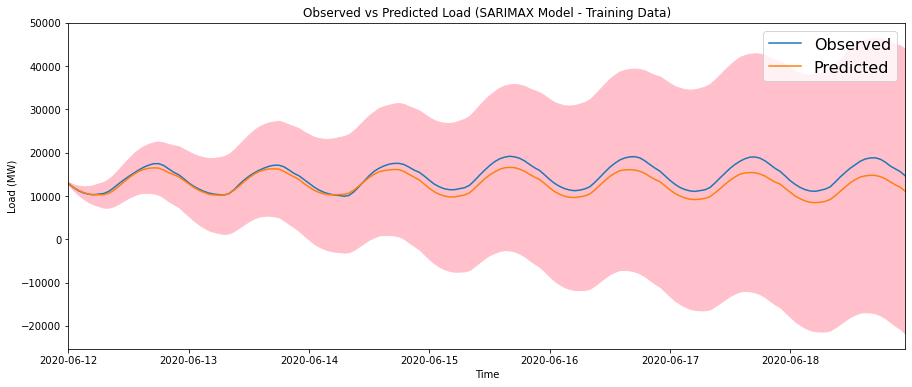

In [115]:
Plot_Pred2(y_train_3yr.iloc[-24*7:], y_pred, 'SARIMAX Model - Training Data',pred_conf_int)

In [126]:
# prediction using test data.
# Predict the first week on hourly level

pred_test = results.get_forecast(steps = 24*7, exog = X_test.iloc[:24*7, :])
pred_test_conf_int = pred_test.conf_int()

y_pred_test = pred_test.predicted_mean
y_lower_limits_test = pred_test_conf_int.loc[:,'lower load']
y_upper_limits_test = pred_test_conf_int.loc[:,'upper load']

In [127]:
ErrorMetrics(y_test.iloc[:24*7],y_pred_test,'SARIMAX prediction using test data')

Error metrics for SARIMAX prediction using test data
R2 score = 0.2779
MAE = 1128.5216
RMSE =  1615.0646
MAPE =  8.2251%


(0.2779051543515788, 1615.0645993839364, 8.22506097026969)

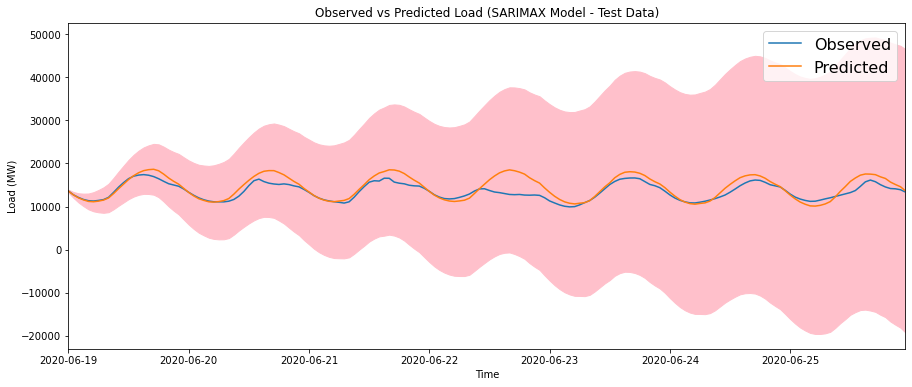

In [128]:
Plot_Pred2(y_test.iloc[:24*7],y_pred_test, 'SARIMAX Model - Test Data',pred_test_conf_int)

The SARIMAX model resulted in MAPE of 8.25% and 11.40% for test and training data respectively. Forecasting for the first few days seem reasonable, however as time increases the confedence interval grew very large. In addition the SRAIMAX model seems to have difficultiy predicting the peak load consumption hours has some anomalies.

Comparing the results to the regression and boosting models, the performance of the SARIMAX model is not acceptable and hence will not be further explored.
<p>&nbsp;</p>

In [ ]:
# Save the models as well us the version of some of the libraries used
SARIMAX_v2_best_model = results
SARIMAX_v2_best_model.version = '1.0'
SARIMAX_v2_best_model.pandas_version = pd.__version__
SARIMAX_v2_best_model.numpy_version = np.__version__
SARIMAX_v2_best_model.sklearn_version = sklearn_version
# SARIMAX_v2_best_model.statsmodels_version = statsmodels.__version__
SARIMAX_v2_best_model.X_columns = [col for col in X_train_3yr.columns]
SARIMAX_v2_best_model.build_datetime = datetime.now()

# save the model

modelpath = './models'
save_file(SARIMAX_v2_best_model, 'SARIMAX_v2_Best_forecasting_model.pkl', modelpath)

<p>&nbsp;</p>


## 5.9 Final Model

We have generated several forecasting models with several iterations of hyper-parameter tuning. From all the models created, the two best prediction models we got were the Elastic Net and the Light GBM models.Light GBM has slight advantage and we will use that as our final model.
<p>&nbsp;</p>

###  5.9.1 Iterative Prediction (hour-by-hour) 

Our best model heavily relies on the lag features we generated. When doing shor-term forecasting in real life scenarios, you don't have the hour lag information. You can only get 1 one-hour lag, therefore you can only predict the load consumption for only the next hour. The you can use the predict load for that hour to generate the lag for the next hour and so on. The forecasting should be done hour-by-hour iteratively.

In the next section, we will read our best Light GBM model and do prediction hour-by-hour iteratively.

In [137]:
# Read the light GBM model generated in the previous notebook

expected_model_version = '1.0'
model_path = './models/LightGBM_Best_forecasting_model.pkl'
if os.path.exists(model_path):
    with open(model_path, 'rb') as f:
        lgbm_mdl = pickle.load(f)
    if lgbm_mdl.version != expected_model_version:
        print("Expected model version doesn't match version loaded")
#     if gbm_mdl.sklearn_version != sklearn_version:
#         print("Warning: model created under different sklearn version")
else:
    print("Expected model not found")

In [164]:
# Prepare the final input data
fr1_coast_df = FourierTerms(lagged_dict['Coast'],1)
col_2_rename = {'sin_hour1':'sin_hour', 'cos_hour1':'cos_hour','sin_week1':'sin_week','cos_week1':'cos_week',\
                'sin_year1':'sin_year','cos_year1':'cos_year'}
fr1_coast_df.rename(columns=col_2_rename,inplace=True)

In [192]:
split_index = 8761

fr1_coast_train = fr1_coast_df.iloc[:-split_index, :]
fr1_coast_test = fr1_coast_df.iloc[-split_index:, :]

# extracting the name of the numeric features
df_numeric_features = fr1_coast_df.copy()
df_numeric_features.drop(columns=['winddir16Point','dates','covid_confirmed','covid_deaths'], inplace=True)

df_numeric_features = df_numeric_features.select_dtypes(include=[np.number])
df_numeric_features.drop(columns=['load'],inplace=True) # drop 'load' as this is our target y value
numeric_features = df_numeric_features.columns

X_train_fnl, X_test_fnl, y_train_fnl, y_test_fnl = SplitEncodeTranf(fr1_coast_train,fr1_coast_test)

X_train_fnl_3yr = X_train_fnl[-26304:]
y_train_fnl_3yr = y_train_fnl[-26304:]

In [194]:

X_traintest = pd.concat([X_train_fnl_3yr,X_test_fnl])
y_traintest = pd.concat([y_train_fnl_3yr,y_test_fnl])

traintest = pd.concat([X_traintest, y_traintest], axis=1)

In [238]:
# traintest.head()

In [228]:
# RUn forecasting for the next 4months. 2927 the number of hours in 4 months
start = timer()

feature = ['load','appr_temp']
train_cols = X_train_fnl_3yr.columns.to_list()
max_lag=8763
start_idx=X_test_fnl.index.min()+timedelta(hours=1)
date_range = pd.date_range(start=start_idx, end=start_idx+timedelta(hours=2927), freq='H')
preds=[]
for idx in date_range:
    beg_idx=idx-timedelta(hours=max_lag)
    drange=pd.date_range(start=beg_idx, end=idx, freq='H')
    df_pred=traintest[traintest.index.isin(drange)].copy()
    df_pred.shape
    
    lag_list=[1,2,3,4,5,6,12,24,48,120,144,168,192,336,360,504,672,768,8064,8760]
    cols=["load"]
    lagged_pred_df = LaggedFeatures(df_pred,feature,lag_list,dropna=False)
    
    df_pred=pd.concat([df_pred, lagged_pred_df], axis=1)
    df_pred=df_pred.loc[:,~df_pred.columns.duplicated()]

    df_pred_roll_mean = df_pred[["load"]].rolling(24).mean().shift()
    df_pred_roll_mean.columns = ["roll_load_mean"]
    df_pred_roll_median = df_pred[["load"]].rolling(24).median().shift()
    df_pred_roll_median.columns = ["roll_load_median"]
    df_pred_roll_max = df_pred[["load"]].rolling(24).max().shift()
    df_pred_roll_max.columns = ["roll_load_max"]
    df_pred_roll_min = df_pred[["load"]].rolling(24).min().shift()
    df_pred_roll_min.columns = ["roll_load_min"]
    df_pred_roll_std = df_pred[["load"]].rolling(24).std().shift()
    df_pred_roll_std.columns = ["roll_load_std"]
    df_pred=pd.concat([df_pred, df_pred_roll_mean, df_pred_roll_median, df_pred_roll_max, df_pred_roll_min, df_pred_roll_std],axis=1)

    df_pred=df_pred.loc[:,~df_pred.columns.duplicated()]
    df_pred = df_pred.dropna()
 
    row=pd.DataFrame(df_pred.iloc[-1][train_cols]).T
    pload=lgbm_mdl.predict(row)
    preds.append(pload)
    traintest.at[idx, 'load']=pload

end = timer()
print('elapsed time is',format(round(end-start)))

elapsed time is 275


In [229]:
# create a dataframe for the final predicted values
date_range=pd.date_range(start=start_idx, end=start_idx+timedelta(hours=2927), freq='H')
df_pred_final=pd.DataFrame(preds, columns=['load-forecast'], index=date_range)
df_pred_final.tail()

,load-forecast
2020-10-18 20:00:00,14849.254850
2020-10-18 21:00:00,14228.508516
2020-10-18 22:00:00,13952.866039
2020-10-18 23:00:00,13320.346809
2020-10-19 00:00:00,12605.066508


In [230]:
df_actual = y_traintest[start_idx : start_idx+timedelta(hours=2927)]
df_actual=pd.DataFrame(df_actual, columns=['load'], index=date_range)
df_actual.tail()

,load
2020-10-18 20:00:00,15001.667495
2020-10-18 21:00:00,14636.384432
2020-10-18 22:00:00,14086.584705
2020-10-18 23:00:00,13471.090302
2020-10-19 00:00:00,12848.750832


In [232]:
ErrorMetrics(df_actual.values,df_pred_final.values,'Final LightGBM Model')

Error metrics for Final LightGBM Model
R2 score = 0.9932
MAE = 168.6008
RMSE =  222.9090
MAPE =  1.1817%


(0.9931564990669715, 222.90902762724477, 1.1816876288360911)

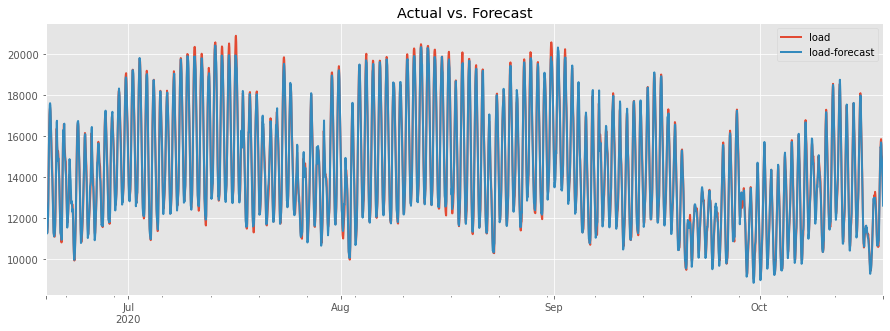

In [243]:
# Plot the predicted vs observed
plt.style.use('ggplot')
xmin=df_actual.index.min()-timedelta(hours=3)
xmax=df_actual.index.max()+timedelta(hours=3)
ax = df_actual.plot(style='-',linewidth=2,
                     figsize=(18,5),title='Actual vs. Forecast',xlim=(xmin,xmax),
                    )
_ = df_pred_final.plot(style='-',linewidth=2, figsize=(15,5), ax=ax)
plt.show()

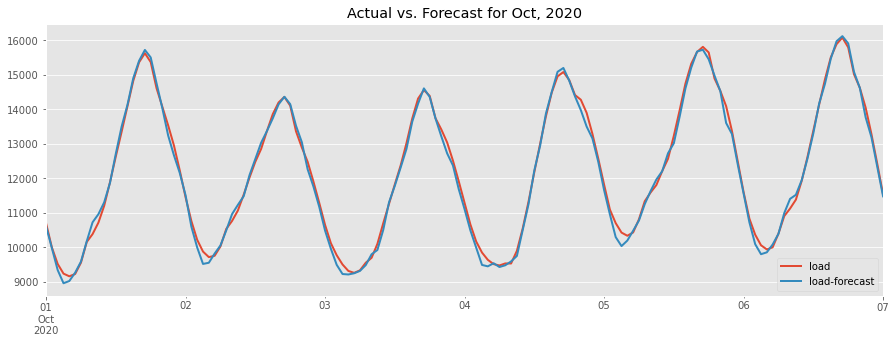

In [240]:
# Plot the predicted vs observed

xmin=df_actual.loc['2020-10-01 00:00:00']
xmax=df_actual.loc['2020-10-07 00:00:00']
ax = df_actual.loc['2020-10-01 00:00:00':'2020-10-07 00:00:00'].plot(style='-',linewidth=2,
                     figsize=(18,5),
#                      color='r',
                     title='Actual vs. Forecast for Oct, 2020',
#                      xlim=(xmin,xmax),
                    )
_ = df_pred_final.loc['2020-10-01 00:00:00':'2020-10-07 00:00:00'].plot(style='-',linewidth=2, figsize=(15,5), ax=ax)
plt.show()

Our model is able to predict the load consumption hour by hour. We have seen that our model's best feature by far is the 1hour lag. If this information is available, our model can predict the laod consumption with great accuracy. With today's smart meters, utility and retails companies can access the electric consumption almost real time, and thus, our model can be effectively deployed to do hourly short-term forecasting.

## 5.10 Conclusion

We have selected the coast weather zone as an example to build a short term forecasting model. Several models were built and compared. Among them, models based on Light GBM and Elastic Net model gave the best performace interms of accuracy and MAPE. THe light GBM model had a marginal performance advantage over Elastic Net model and was selected as the final model. 


Some observations and lessons learned:

- Energy consumption is none-stationary. It has trend as well as multiple seasonalities (daily, yearly). THis is probably one of the main reasons why the SARIMAX model performed poorly.
- As expected, electric load usage is highly correlated to temperature. Therfore , accurate weather forecast is needed to get a good load forecasting.
- Knowledge of previous few hours load consumption is very crucial for short-term forecasting. If these information are available, a very accurate (with MAPE < 1%) forecasting can be achieved. With today's techonolgies, smart meters are readily availbale in most location. Utilities and retailers that have access to smart meters can take advantage of that data and build robust short-term forecasting models

## 5.11 Future works

One of the methods that was not tested in this project was Long Short-Term Memory (LSTM) method. A forecasting model based on recurent neural network would be an interseting project. It would be worth exploring the accuracy  and run time of LSTM based model vs GBM methods. Another method not tested due to time limitation is FaceBook's Prohet package. 